In [173]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from gurobipy import GRB
import re
import datetime
import ast
from tqdm.notebook import tqdm

In [174]:
from tests.utils import *

## Master problem correctness

In [238]:
file_name = "test7_slack12"
n = 200
K = 5
seed = 5
l = 3
alpha = 1/2
beta = [1, 1, 1]
lower = 2
upper = n
M = 1e6
np.random.seed(seed)
labels = np.random.choice([0, 1, 2], p=[0.1, 0.2, 0.7], size=n)

X, Y, archetype = synthetic_data(n, K, seed)
_, _, q, clusters_init, _, t = initialize_clusters(
    X, K, l, alpha, beta, n, labels, M, lower, upper)

Optimizing Cluster Centers: 100%|██████████| 300/300 [00:00<00:00, 3042.05it/s, Status=SUCCESS]


In [176]:
model = gp.read("./tests/model_write/" + file_name + "_out1000.lp")
constrs_len = len(model.getConstrs())
print(constrs_len)
clusters = np.loadtxt("./tests/model_matrix/"+file_name+"_clusters.txt")
distances = np.loadtxt("./tests/model_matrix/"+file_name+"_distances.txt")
slacks = np.loadtxt("./tests/model_matrix/"+file_name+"_slacks.txt")
solutions = np.loadtxt("./tests/model_matrix/"+file_name+"_solutions.txt")
objectives = np.loadtxt("./tests/model_matrix/"+file_name+"_objectives.txt")

Read LP format model from file ./tests/model_write/test7_slack12_out1000.lp
Reading time = 0.65 seconds
: 204 rows, 9587 columns, 794929 nonzeros
204


In [177]:
clusters = np.concatenate((clusters,np.ones(clusters.shape[0]).reshape(-1,1)),axis=1)
A = [[model.getCoeff(constr, var) for var in model.getVars()] for constr in model.getConstrs()]
b = [constr.rhs for constr in model.getConstrs()]
c = [var.obj for var in model.getVars()]
induced_mat = np.concatenate((clusters[:K,:],np.eye(constrs_len-1,constrs_len),clusters[K:,:]),axis=0).T
A = np.array(A)

Compare the linear system of constraints from the last iteration of Gurobi with the cluster representations

In [178]:
np.allclose(induced_mat[:,:A.shape[1]],A)

True

In [179]:
dist_gurobi = np.array(c[:K] + c[K + constrs_len-1:])
dist_stored = np.array(distances)[:dist_gurobi.shape[0]]

Compare the coefficients of variables in the objective from the last iteration of Gurobi with the cluster representations

In [180]:
np.allclose(dist_gurobi,dist_stored)

True

Reoptimize the model using the Gurobi output of the master problem from the last iteration

In [181]:
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 204 rows, 9587 columns and 794929 nonzeros
Model fingerprint: 0x85c27925
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve time: 0.58s
Presolved: 204 rows, 9587 columns, 794929 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.065e+04
 Factor NZ  : 2.091e+04 (roughly 4 MB of memory)
 Factor Ops : 2.851e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.20714748e+06  0.00000

In [182]:
objectives[-1], model.ObjVal

(786.1297149421915, 786.129714942192)

In [183]:
last_sol_gurobi = [var.X for var in model.getVars()]
last_sol_gurobi_Z = last_sol_gurobi[:K] + last_sol_gurobi[K + constrs_len-1:]
last_sol_gurobi_slackness = last_sol_gurobi[K:K + constrs_len-1]

In [195]:
np.allclose(last_sol_gurobi_Z, solutions[-1], atol = 1e-5)

True

check partition constraints

In [224]:
valid = True
for j in range(0,1000,20):
    partition_constr = [clusters[:solutions[j].shape[0],i] @ solutions[j] + slacks[j][i] for i in range(n)]
    valid = valid and (np.allclose(np.array(partition_constr),np.ones(n),rtol=1e-3))

In [223]:
print(valid)

True


check number of clusters constraint

In [225]:
np.sum(solutions[-1])

5.0

checks the cluster representation of t of the same as the t in the LP

In [199]:
m = solutions[-1].shape[0]

In [200]:
t1 = []
t2 = []
for i in (range(m)):
    t_vector = []
    for j in range(l):
        cluster = clusters[i,:n]
        size = sum(cluster)
        group_size = cluster @ q[j]
        if group_size >= alpha * size:
            t_vector.append(1)
        else:
            t_vector.append(0)
    t1.append(t_vector)
    t2.append(clusters[i,n:n+l])

In [201]:
np.allclose(t1,t2,rtol=1e-3)

True

check fairness constraint

In [226]:
for i in range(n,n+l):
    print(solutions[-1] @ clusters[:solutions[-1].shape[0],i] + slacks[-1][i])

1.000003802141342
0.9999978573416903
4.485950000000001


compares the solutions from Gurobi's log file with the stored solutions

In [204]:
import pandas as pd

In [205]:
df = pd.read_csv("./tests/model_write/" + file_name + "_out501.sol", sep = " ")

In [206]:
last_solution_gurobi = df['Solution'][1:].to_numpy(dtype=float)

In [207]:
last_solution_gurobi_Z = np.concatenate((last_solution_gurobi[:K], last_solution_gurobi[K + constrs_len - 1:]))

In [208]:
last_solution_gurobi_slackness = last_solution_gurobi[K:K + constrs_len - 1]

In [209]:
np.allclose(last_solution_gurobi_slackness, slacks[500], atol = 1e-3)

True

In [210]:
np.allclose(last_solution_gurobi_Z, solutions[500][:last_solution_gurobi_Z.shape[0]], atol = 1e-3)

True

## Visualizations

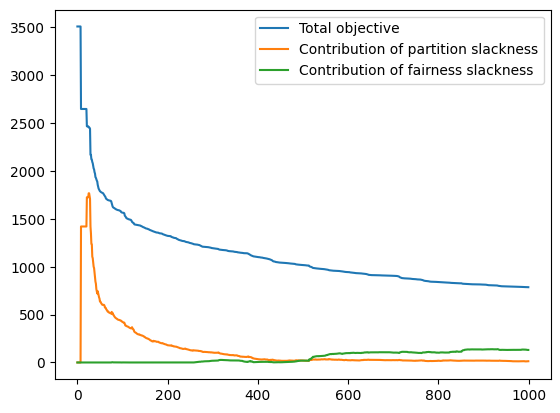

In [227]:
partition_slacks = [20 * sum(i[:n]) for i in slacks]
fairness_slacks = [100 * sum(i[n:]) for i in slacks]
plt.plot(objectives, label = "Total objective")
plt.plot(partition_slacks, label = "Contribution of partition slackness")
plt.plot(fairness_slacks, label = "Contribution of fairness slackness")
plt.legend()
plt.show()

In [228]:
import seaborn as sns

In [230]:
cmap = sns.cm.rocket_r

In [231]:
fig = plt.figure(dpi = 1000)
sns.heatmap(solutions,cmap = cmap,vmax = 0.1)
fig.savefig("./tests/images/heatmap_"+ file_name +".png")
plt.close()

In [306]:
def create_df(solution):
    indices = list(range(len(solution)))
    indices_sorted = sorted(indices,key= lambda i : -solution[i])
    solutions_sorted = np.array(solution)[indices_sorted]
    fairness_rep = [tuple(c[n:n+l]) for c in clusters[indices_sorted]]
    df = pd.DataFrame({"Cluster Number": indices_sorted, 
                        "Solution": solutions_sorted,
                        "Cluster cost": np.array(distances)[indices_sorted], 
                        "Size of cluster": np.sum(np.array(clusters)[indices_sorted,:n],axis = 1),
                        "Fairness": fairness_rep})
    
    coverages,overlaps = coverage(list(df['Cluster Number']))
    df['coverage'] = coverages
    df['overlap'] = overlaps
    
    return df

In [307]:
def coverage(cluster_nums):
    cover = np.zeros(n)
    coverages = []
    overlaps = []
    for i in cluster_nums:
        cover += clusters[i][:n]
        coverage = 0
        overlap = 0
        for i in cover:
            if i > 0:
                coverage += 1
            if i > 1:
                overlap += i - 1
        coverages.append(coverage)
        overlaps.append(overlap)
    return coverages,overlaps

In [308]:
df = create_df(solutions[-1])

In [309]:
df[:20]

,Cluster Number,Solution,Cluster cost,Size of cluster,Fairness,coverage,overlap
0,4891,0.65305,34.312407,24.0,"(0.0, 0.0, 1.0)",24,0.0
1,8018,0.36538,68.255547,42.0,"(0.0, 0.0, 1.0)",66,0.0
2,6948,0.24385,35.991562,26.0,"(0.0, 0.0, 1.0)",92,0.0
3,5795,0.19067,153.832743,41.0,"(0.0, 0.0, 1.0)",109,24.0
4,7771,0.16965,115.546333,41.0,"(0.0, 0.0, 1.0)",138,36.0
5,6906,0.15837,81.923156,16.0,"(1.0, 1.0, 0.0)",138,52.0
6,6732,0.15190,90.552838,46.0,"(0.0, 0.0, 1.0)",183,53.0
7,5728,0.14191,63.848650,40.0,"(0.0, 0.0, 1.0)",189,87.0
8,4992,0.14137,40.790274,27.0,"(0.0, 0.0, 1.0)",189,114.0
9,7809,0.13974,175.190601,51.0,"(0.0, 0.0, 1.0)",191,163.0


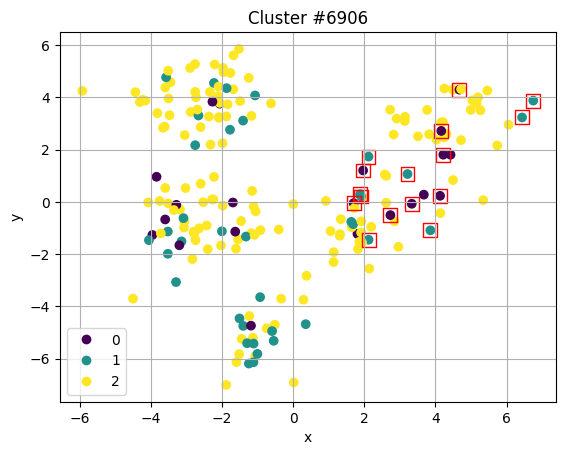

In [310]:
cluster_num = 6906
cluster_x = []
cluster_y = []
for i,j in enumerate(clusters[cluster_num][:n]):
    if j == 1:
        cluster_x.append(X[:,0][i])
        cluster_y.append(X[:,1][i])

scatter = plt.scatter(X[:,0],X[:,1],c=labels,label="Groups")
plt.scatter(cluster_x,cluster_y,marker="s",edgecolors="r",facecolors='none',s=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cluster #' + str(cluster_num))
plt.grid(True)
plt.legend(handles=scatter.legend_elements()[0], labels=[0,1,2])
plt.show()

## Parameters

In [311]:
Zvars = model.getVars()[:K] + model.getVars()[K + constrs_len-1:]
Slack_vars_partition = model.getVars()[K : K + n]
Slack_vars_represent = model.getVars()[K + n : K + n + l]

In [251]:
len(Zvars) + len(Slack_vars_partition) + len(Slack_vars_represent) == len(model.getVars())

True

In [255]:
objective = gp.quicksum(Zvars[i] * dist_gurobi[i] for i in range(len(Zvars))) + \
    gp.quicksum(i * 1000 for i in Slack_vars_partition) + \
    gp.quicksum(i * 1000 for i in Slack_vars_represent)
model.setObjective(objective, GRB.MINIMIZE)
model.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 204 rows, 9587 columns and 794929 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
LP warm-start: use basis


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.7235298e+37   1.865629e+35   5.386031e+05      0s
     770    9.1214831e+02   0.000000e+00   0.000000e+00      3s

Solved in 770 iterations and 2.60 seconds (1.82 work units)
Optimal objective  9.121483104e+02


In [271]:
sum(var.X for var in Slack_vars_partition) == 0, sum(var.X for var in Slack_vars_represent) == 0

(True, True)

In [275]:
solution_no_slack = np.array([z.X for z in Zvars])

In [279]:
np.allclose(np.ones(n),[clusters[:len(solution_no_slack),i] @ solution_no_slack for i in range(n)])

True

In [281]:
for i in range(n,n+l):
    print(solution_no_slack @ clusters[:solution_no_slack.shape[0],i])

1.0
1.0
3.9137174954378144


In [312]:
df2 = create_df(solution_no_slack)

In [313]:
df2[:20]

,Cluster Number,Solution,Cluster cost,Size of cluster,Fairness,coverage,overlap
0,2,0.468874,17.206204,2.0,"(1.0, 1.0, 0.0)",2,0.0
1,4891,0.396330,34.312407,24.0,"(0.0, 0.0, 1.0)",26,0.0
2,5795,0.170712,153.832743,41.0,"(0.0, 0.0, 1.0)",67,0.0
3,6906,0.112113,81.923156,16.0,"(1.0, 1.0, 0.0)",76,7.0
4,6732,0.109275,90.552838,46.0,"(0.0, 0.0, 1.0)",122,7.0
5,6725,0.096784,128.153032,50.0,"(0.0, 0.0, 1.0)",133,46.0
6,6916,0.096208,67.763733,14.0,"(1.0, 1.0, 0.0)",134,59.0
7,5201,0.084621,40.075361,2.0,"(1.0, 1.0, 0.0)",135,60.0
8,6087,0.080534,190.302710,56.0,"(0.0, 0.0, 1.0)",142,109.0
9,8428,0.074885,181.348195,44.0,"(0.0, 0.0, 1.0)",147,148.0


In [284]:
c2 = [var.obj for var in model.getVars()]
c2 == c

In [76]:
def get_nonzeros(l):
    res = []
    for i,j in enumerate(l):
        if j != 0:
            res.append(i)
    #print(l)
    print(res)